In [ ]:
# Import required libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.optimizers import Adam

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
'''def reshape_data(data):
    # Reshape data to (samples, time steps, features)
    n_features = data.shape[1]
    total_elements = data.values.shape[0]
    sequence_length = 10
    new_shape = (-1, sequence_length, n_features)
    padding = None
    
    # Check if total elements is divisible by the product of sequence length and number of features
    if total_elements % (sequence_length * n_features) != 0:
        # Calculate the number of elements needed for padding
        padding_elements = (sequence_length * n_features) - (total_elements % (sequence_length * n_features))
        padding = str(padding_elements / total_elements * 100) + "% added as padding"

        # Pad the data with zeros
        data_values_padded = np.pad(data.values, ((0, padding_elements), (0, 0)), mode='constant')
        reshaped_data = np.reshape(data_values_padded, new_shape)
    else:
        # No padding required
        reshaped_data = np.reshape(data.values, new_shape)
    
    return reshaped_data, padding'''

'def reshape_data(data):\n    # Reshape data to (samples, time steps, features)\n    n_features = data.shape[1]\n    total_elements = data.values.shape[0]\n    sequence_length = 10\n    new_shape = (-1, sequence_length, n_features)\n    padding = None\n    \n    # Check if total elements is divisible by the product of sequence length and number of features\n    if total_elements % (sequence_length * n_features) != 0:\n        # Calculate the number of elements needed for padding\n        padding_elements = (sequence_length * n_features) - (total_elements % (sequence_length * n_features))\n        padding = str(padding_elements / total_elements * 100) + "% added as padding"\n\n        # Pad the data with zeros\n        data_values_padded = np.pad(data.values, ((0, padding_elements), (0, 0)), mode=\'constant\')\n        reshaped_data = np.reshape(data_values_padded, new_shape)\n    else:\n        # No padding required\n        reshaped_data = np.reshape(data.values, new_shape)\n    \n   

In [3]:
'''def reshape_data(data):
    # Reshape data to (samples, time steps, features)
    total_elements = data.values.shape[0]
    sequence_length = 2
    n_features = data.shape[1]
    new_shape = (-1, sequence_length, n_features)
    
    # Calculate the number of elements needed for padding
    padding_elements = sequence_length * n_features - (total_elements % (sequence_length * n_features))
    
    # Check if padding is required
    if padding_elements > 0:
        # Pad the data with zeros
        data_values_padded = np.pad(data.values, ((0, padding_elements), (0, 0)), mode='constant')
        reshaped_data = np.reshape(data_values_padded, new_shape)
    else:
        # No padding required
        reshaped_data = np.reshape(data.values, new_shape)
    
    return reshaped_data'''

"def reshape_data(data):\n    # Reshape data to (samples, time steps, features)\n    total_elements = data.values.shape[0]\n    sequence_length = 2\n    n_features = data.shape[1]\n    new_shape = (-1, sequence_length, n_features)\n    \n    # Calculate the number of elements needed for padding\n    padding_elements = sequence_length * n_features - (total_elements % (sequence_length * n_features))\n    \n    # Check if padding is required\n    if padding_elements > 0:\n        # Pad the data with zeros\n        data_values_padded = np.pad(data.values, ((0, padding_elements), (0, 0)), mode='constant')\n        reshaped_data = np.reshape(data_values_padded, new_shape)\n    else:\n        # No padding required\n        reshaped_data = np.reshape(data.values, new_shape)\n    \n    return reshaped_data"

In [3]:
# List of all stocks
stocks = ['aapl', 'amzn', 'googl', 'msft', 'tsla']

# Get rid of annoying errors that don't matter
pd.set_option('mode.chained_assignment', None)

# Create the scaler
scaler = MinMaxScaler()

# Create the datasets from the csvs
# Could use a lot of work to reduce loc but it doesn't matter for marks
def dataFrames(stock):

    # Create dataframes for the tweets and prices 
    tweet_df = pd.read_csv('csv/' + stock + '.csv')
    tweet_1_df = pd.read_csv('csv/' + stock + '_1.csv')
    price_df = pd.read_csv('csv/' + stock + '_price.csv')

    # Rename the date column so they match between dataframes
    tweet_df.rename(columns = {'DATE': 'date'}, inplace = True)
    tweet_1_df.rename(columns = {'Date': 'date'}, inplace = True)
    price_df.rename(columns = {'Date' : 'date', 'Close/Last': 'stockPrice'}, inplace = True)

    # Rename the score column so they match between dataframes
    tweet_df.rename(columns = {'TEXTBLOB_POLARITY': 'sentimentScore'}, inplace = True)
    tweet_1_df.rename(columns = {'score': 'sentimentScore'}, inplace = True)

    # Remove the $ sign in stock price, and convert columns to float64 (may be redundant)
    price_df['stockPrice'] = price_df['stockPrice'].str.replace('$', '')
    tweet_df['sentimentScore'] = pd.to_numeric(tweet_df['sentimentScore'])
    tweet_1_df['sentimentScore'] = pd.to_numeric(tweet_1_df['sentimentScore'])
    price_df['stockPrice'] = pd.to_numeric(price_df['stockPrice'])

    # Convert the dates to pd datetime
    price_df['date'] = pd.to_datetime(price_df['date'])
    tweet_df['date'] = pd.to_datetime(tweet_df['date'], dayfirst = True)
    tweet_1_df['date'] = pd.to_datetime(tweet_1_df['date'])

    # Reduce to only nessicary columns
    tweet_df = tweet_df[['date', 'sentimentScore']]
    tweet_1_df = tweet_1_df[['date', 'sentimentScore']]
    price_df = price_df[['date', 'stockPrice']]

    # Merge the dataframes based on the date column
    merged_1_df = pd.merge(tweet_df, price_df, on = 'date')
    merged_2_df = pd.merge(tweet_1_df, price_df, on = 'date')
    merged_df = pd.merge(merged_1_df, merged_2_df, how = 'outer')

    # Drop all duplicates
    final_df = merged_df.drop_duplicates()

    # Convert date to specific variables
    final_df['year'] = final_df['date'].dt.year
    final_df['month'] = final_df['date'].dt.month
    final_df['day'] = final_df['date'].dt.day
    final_df['day_of_week'] = final_df['date'].dt.dayofweek

    # One-hot encoding, should be done for all for financial data
    final_df = pd.get_dummies(final_df, columns = ['year', 'month', 'day', 'day_of_week'])

    # Drop the original date column
    final_df = final_df.drop(columns = ['date'])

    # Save to csv for double checking
    #final_df.to_csv('final_' + stock + '.csv', index = False)

    # Scale the numerical values
    final_df[['stockPrice', 'sentimentScore']] = scaler.fit_transform(final_df[['stockPrice', 'sentimentScore']])

    # Split into X and y
    X = final_df.drop(columns = ['stockPrice'])
    y = final_df['stockPrice']

    # Split the datasets into training and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    '''# Reshape the datasets
    X_train_reshaped = reshape_data(X_train)
    X_test_reshaped = reshape_data(X_test)'''

    # NOTE: Sequence length (1) could be improved by making one of the commented functions above work.
    X_train_reshaped = np.reshape(X_train, (-1, 1, X_train.shape[1]))
    X_test_reshaped = np.reshape(X_test, (-1,  1, X_test.shape[1]))
    y_train_array = y_train.values
    y_test_array = y_test.values

    # Return the training and test datasets
    return X_train_reshaped, X_test_reshaped, y_train_array, y_test_array

In [ ]:
all_data = {}  # Dictionary to hold data for all stocks

for stock in stocks:
    # Run the 'dataFrames' function for each stock
    data = dataFrames(stock)
    
    # Store the datasets in the dictionary
    all_data[stock] = {
        'X_train': data[0],
        'X_test': data[1],
        'y_train': data[2],
        'y_test': data[3]
    }

    # Print the shapes of X_train and y_train for the current stock
    print(f"{stock} X_train shape: {data[0].shape}")
    print(f"{stock} y_train shape: {data[2].shape}")

FileNotFoundError: [Errno 2] No such file or directory: 'csv/aapl_1.csv'

In [6]:
'''# Reshape X
X = X.reshape(-1, 1, 1)

# Split X and Y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# More reshaping that needs to be fixed
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))'''

'# Reshape X\nX = X.reshape(-1, 1, 1)\n\n# Split X and Y into train and test sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)\n\n# More reshaping that needs to be fixed\nX_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))\nX_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))'

In [7]:
'''# Define the variable 'final_df' before reshaping X_train
final_df = merged_df[['sentimentScore', 'stockPrice']]

# Define the variable 'X_train' before reshaping it
X_train = final_df['sentimentScore'].values

# Reshape X_train
X_train = X_train.reshape(-1, 1, 1)

# LSTM Model with Dropout and Dense
model = Sequential([
    Input(shape = X_train.shape[1:]),
    LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1:], 1)),
    Dropout(0.2), 
    LSTM(units = 50, return_sequences = True),
    Dropout(0.2),
    LSTM(units = 50),
    Dropout(0.2),
    Dense(units = 1)
])

# Use the Adam optimizer
model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'mean_squared_error')'''


"# Define the variable 'final_df' before reshaping X_train\nfinal_df = merged_df[['sentimentScore', 'stockPrice']]\n\n# Define the variable 'X_train' before reshaping it\nX_train = final_df['sentimentScore'].values\n\n# Reshape X_train\nX_train = X_train.reshape(-1, 1, 1)\n\n# LSTM Model with Dropout and Dense\nmodel = Sequential([\n    Input(shape = X_train.shape[1:]),\n    LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1:], 1)),\n    Dropout(0.2), \n    LSTM(units = 50, return_sequences = True),\n    Dropout(0.2),\n    LSTM(units = 50),\n    Dropout(0.2),\n    Dense(units = 1)\n])\n\n# Use the Adam optimizer\nmodel.compile(optimizer = Adam(learning_rate = 0.001), loss = 'mean_squared_error')"

In [5]:

# Initialize dictionary to store the models for each stock
models = {}

for stock, datasets in all_data.items():
    X_train = datasets['X_train']
    y_train = datasets['y_train']
    X_test = datasets['X_test']
    y_test = datasets['y_test']
    
    # Define the model for current stock
    model = Sequential([
        Input(shape=X_train.shape[1:]),
        LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1:], 1)),
        Dropout(0.2), 
        LSTM(units=50, return_sequences=True),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(units=1)
    ])

    # Convert data type of input arrays to float32
    X_train = X_train.astype('float32')
    y_train = y_train.astype('float32')
    X_test = X_test.astype('float32')
    y_test = y_test.astype('float32')

    # Compile model using the Adam optimizer
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    # Ensure that X_train and y_train have the same number of samples (if necessary)
    X_train = X_train[:len(y_train)]

    # Fit the model with verbose settings for debugging
    model.fit(X_train, y_train, epochs=500, batch_size=32, verbose=1)

    # Evaluate the model and print the loss
    loss = model.evaluate(X_test, y_test)
    print(f"{stock} Test Loss: ", loss)

    # Store the model in the dictionary
    models[stock] = model

NameError: name 'X_train' is not defined

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

for stock in stocks:
    # Process and prepare data for each stock
    X_train, X_test, y_train, y_test = dataFrames(stock) 

    # Flatten X data for compatibility with RandomForest, Linear Regression, and Decision Tree
    num_samples, timesteps, num_features = X_train.shape
    X_train_2d = X_train.reshape(num_samples, timesteps * num_features)
    X_test_2d = X_test.reshape(X_test.shape[0], timesteps * num_features)

    # Store processed data
    all_data[stock] = (X_train_2d, X_test_2d, y_train, y_test)

# Initialize dictionaries for models and their performances
rf_models = {}
rf_losses = {}
lr_models = {}
lr_losses = {}
dt_models = {}
dt_losses = {}

for stock, (X_train_2d, X_test_2d, y_train, y_test) in all_data.items():
    # RandomForestRegressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_2d, y_train)
    rf_predictions = rf_model.predict(X_test_2d)
    rf_loss = mean_squared_error(y_test, rf_predictions)
    rf_models[stock] = rf_model
    rf_losses[stock] = rf_loss
    print(f"{stock} Random Forest Test Loss: ", rf_loss)

    # Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_train_2d, y_train)
    lr_predictions = lr_model.predict(X_test_2d)
    lr_loss = mean_squared_error(y_test, lr_predictions)
    lr_models[stock] = lr_model
    lr_losses[stock] = lr_loss
    print(f"{stock} Linear Regression Test Loss: ", lr_loss)
    
    # Decision Tree Regressor
    dt_model = DecisionTreeRegressor(random_state=42)
    dt_model.fit(X_train_2d, y_train)
    dt_predictions = dt_model.predict(X_test_2d)
    dt_loss = mean_squared_error(y_test, dt_predictions)
    dt_models[stock] = dt_model
    dt_losses[stock] = dt_loss
    print(f"{stock} Decision Tree Test Loss: ", dt_loss)

Random Forest Test Loss:  1.0748355965980684e-08


In [12]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Initialize dictionaries for GaussianNB models and their accuracies
gaussian_nb_models = {}
gaussian_nb_accuracies = {}

# Label encoder to convert continuous labels to discrete integers
label_encoder = LabelEncoder()

for stock, (X_train_2d, X_test_2d, y_train, y_test) in all_data.items():
    # Convert continuous labels to discrete integers
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Define and initialize the Gaussian Naive Bayes model
    bayes_model = GaussianNB()

    # Fit the model with the reshaped 2D training data and encoded labels
    bayes_model.fit(X_train_2d, y_train_encoded)

    # Make predictions on the reshaped 2D test data
    bayes_predictions = bayes_model.predict(X_test_2d)

    # Calculate and print the accuracy for the test set predictions
    accuracy = accuracy_score(y_test_encoded, bayes_predictions)
    print(f"{stock} Gaussian Naive Bayes Test Accuracy: ", accuracy)

    # Store the model and its accuracy
    gaussian_nb_models[stock] = bayes_model
    gaussian_nb_accuracies[stock] = accuracy

Gaussian Naive Bayes Test Accuracy:  0.9983290011139992


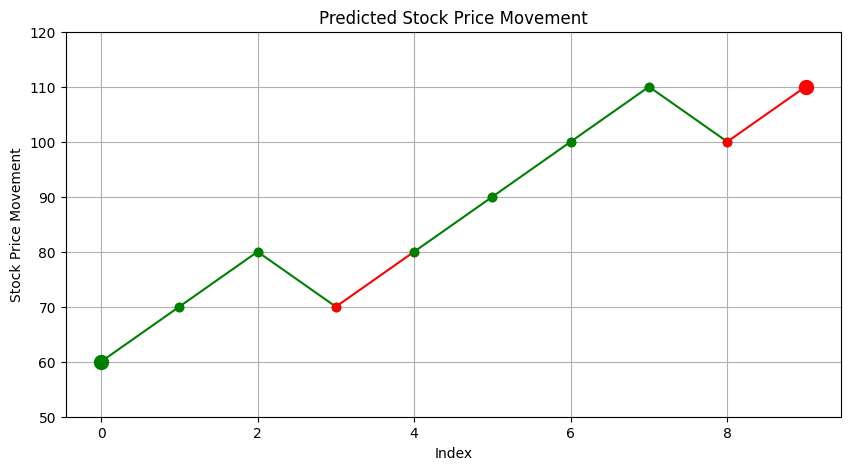

In [15]:
binary_predictions = {}  # Initialize an empty dictionary to store binary predictions for each stock

for stock, model in models.items():    
    # Retrieve the reshaped 2D training data and original labels for current stock
    X_train_2d, X_test_2d, y_train, y_test = all_data[stock]
    
    # Predict the stock prices using the trained model
    y_pred = model.predict(X_test_2d)
    
    # Create binary predictions: 1 if the predicted next day's price is higher than the current day's actual price, else 0
    y_pred_binary = np.where(y_pred[:-1] > y_test[1:], 1, 0)  # Compare each prediction to the next day's actual
    
    # Store the binary predictions in the dictionary
    binary_predictions[stock] = y_pred_binary.flatten()

    # Optionally, print the last 10 predicted binary values for the current stock
    pred_values = y_pred_binary.flatten()[-10:]
    print(f"{stock} Predicted values:", pred_values)
    
for stock, newpred_values in binary_predictions.items():
    # Start at a base value (e.g., 50) for the y-axis
    y_values = [50]
    for change in newpred_values:
        # Increase or decrease the stock price based on the prediction
        y_values.append(y_values[-1] + (10 if change == 1 else -10))

    # Now plot the zigzag graph for the current stock
    plt.figure(figsize=(10, 5))
    plt.title(f'Predicted Stock Price Movement for {stock.upper()}')

    # Plot the lines and points
    for i in range(1, len(y_values)):
        # Choose color based on the prediction
        color = 'green' if newpred_values[i-1] == 1 else 'red'
        plt.plot([i-1, i], [y_values[i-1], y_values[i]], color=color, marker='o')

    # Mark the starting and ending points with larger dots
    plt.plot(0, y_values[0], 'go', markersize=10)  # Starting point
    plt.plot(len(newpred_values) - 1, y_values[-1], 'ro', markersize=10)  # Ending point

    # Set labels and adjust the plot
    plt.xlabel('Index')
    plt.ylabel('Stock Price Movement')
    plt.grid(True)
    plt.ylim(min(y_values) - 10, max(y_values) + 10)

    # Display the plot
    plt.show()


In [1]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import numpy as np

# Download historical data
data = yf.download('AAPL','2020-01-01','2024-04-05')

# Preprocess data
data['Close'] = data['Close'].astype(float)
data = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split data into training and testing sets
train_data = scaled_data[0:int(len(scaled_data)*0.8), :]
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Define LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compile and fit the model
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

# Test the model
test_data = scaled_data[len(train_data) - 60:, :]
x_test = []
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Print predictions
print(predictions)

[*********************100%%**********************]  1 of 1 completed
/Users/alijaffar/opt/miniconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


796/796 - 7s - 9ms/step - loss: 0.0048
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[178.79413]
 [178.91911]
 [179.27074]
 [179.7232 ]
 [180.42398]
 [181.2725 ]
 [182.04529]
 [182.70062]
 [183.13257]
 [183.61263]
 [184.09189]
 [184.749  ]
 [185.40988]
 [186.08154]
 [186.8626 ]
 [187.5551 ]
 [188.16113]
 [188.58809]
 [189.11278]
 [189.6068 ]
 [189.94414]
 [190.38509]
 [190.92189]
 [191.49672]
 [192.38641]
 [193.252  ]
 [193.97246]
 [194.59741]
 [195.02489]
 [195.15094]
 [195.05843]
 [194.96767]
 [194.92491]
 [194.92017]
 [195.19118]
 [195.56291]
 [196.08162]
 [196.49095]
 [196.7327 ]
 [196.92479]
 [197.12851]
 [197.3833 ]
 [197.54536]
 [197.85187]
 [198.2461 ]
 [198.5981 ]
 [198.67589]
 [198.49994]
 [197.48827]
 [195.8817 ]
 [194.11246]
 [192.22905]
 [190.40593]
 [188.73656]
 [187.40935]
 [186.22418]
 [185.16708]
 [184.07933]
 [183.10883]
 [182.37537]
 [181.93546]
 [181.99377]
 [181.97269]
 [182.11743]
 [182.45285]
 [183.16853]
 [184.30666]
 [185.61835]
 [187.06781]
 [188.50407]
 [189.31004]


In [2]:
def predict_stock(symbol):
    # Download historical data
    data = yf.download(symbol,'2020-01-01','2024-04-05')

    # Preprocess data
    data['Close'] = data['Close'].astype(float)
    data = data['Close'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Split data into training and testing sets
    train_data = scaled_data[0:int(len(scaled_data)*0.8), :]
    x_train, y_train = [], []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Define LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))

    # Compile and fit the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

    # Test the model
    test_data = scaled_data[len(train_data) - 60:, :]
    x_test = []
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Print predictions
    print(predictions)

# List of stock symbols
stocks = ['AAPL', 'AMZN', 'GOOG', 'MSFT', 'TSLA']

# Predict for each stock
for stock in stocks:
    print(f"Predictions for {stock}:")
    predict_stock(stock)

[*********************100%%**********************]  1 of 1 completed

Predictions for AAPL:



/Users/alijaffar/opt/miniconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


796/796 - 7s - 9ms/step - loss: 0.0033
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[173.34761]
 [173.46387]
 [173.89024]
 [174.44019]
 [175.29344]
 [176.3025 ]
 [177.16388]
 [177.83011]
 [178.1783 ]
 [178.58705]
 [178.99974]
 [179.6519 ]
 [180.30634]
 [180.96802]
 [181.7665 ]
 [182.43684]
 [182.98523]
 [183.29897]
 [183.7547 ]
 [184.18288]
 [184.41557]
 [184.80217]
 [185.32858]
 [185.90794]
 [186.89714]
 [187.83241]
 [188.54802]
 [189.12086]
 [189.42964]
 [189.35332]
 [189.0235 ]
 [188.74817]
 [188.5884 ]
 [188.52002]
 [188.84328]
 [189.30441]
 [189.94524]
 [190.4158 ]
 [190.64168]
 [190.79288]
 [190.96059]
 [191.19943]
 [191.31796]
 [191.63158]
 [192.06099]
 [192.4257 ]
 [192.42027]
 [192.08798]
 [190.68335]
 [188.57422]
 [186.38054]
 [184.17644]
 [182.18028]
 [180.48956]
 [179.3164 ]
 [178.35342]
 [177.55   ]
 [176.67867]
 [175.9293 ]
 [175.45428]
 [175.31535]
 [175.76436]
 [176.01982]
 [176.4086 ]
 [176.97166]
 [177.95842]
 [179.41478]
 [180.99962]
 [182.6649 ]
 [184.22101]
 [184.87468]


[*********************100%%**********************]  1 of 1 completed
/Users/alijaffar/opt/miniconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


796/796 - 7s - 9ms/step - loss: 0.0052
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[123.31626 ]
 [124.09748 ]
 [124.71767 ]
 [125.1068  ]
 [125.39682 ]
 [125.66119 ]
 [125.99108 ]
 [126.43172 ]
 [126.55812 ]
 [126.47425 ]
 [126.27065 ]
 [126.106964]
 [125.98169 ]
 [125.88984 ]
 [125.92993 ]
 [125.92578 ]
 [125.887184]
 [125.643135]
 [125.47767 ]
 [125.300705]
 [124.85289 ]
 [124.26897 ]
 [123.77989 ]
 [123.30075 ]
 [122.936134]
 [122.63908 ]
 [122.55672 ]
 [122.49206 ]
 [122.39543 ]
 [122.05299 ]
 [121.64229 ]
 [121.34201 ]
 [121.495834]
 [121.982765]
 [122.6139  ]
 [123.23205 ]
 [123.70876 ]
 [123.82938 ]
 [123.77201 ]
 [123.70522 ]
 [123.69495 ]
 [124.211136]
 [125.03053 ]
 [126.226234]
 [127.58606 ]
 [128.87482 ]
 [129.79745 ]
 [130.43501 ]
 [130.81871 ]
 [131.25432 ]
 [131.67235 ]
 [131.93362 ]
 [132.08958 ]
 [132.16331 ]
 [132.29974 ]
 [132.3488  ]
 [132.26375 ]
 [132.20038 ]
 [131.97873 ]
 [131.74101 ]
 [131.55942 ]
 [131.67918 ]
 [131.77217 ]
 [131.87811 ]
 [132.0623  ]
 [132.54692 ]

[*********************100%%**********************]  1 of 1 completed
/Users/alijaffar/opt/miniconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def calculate_and_plot_metrics(y_true, y_pred):
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    # Print metrics
    print(f"MSE: {mse}")
    print(f"MAE: {mae}")

    # Plot metrics
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("MSE")
    plt.bar(['MSE'], [mse])

    plt.subplot(1, 2, 2)
    plt.title("MAE")
    plt.bar(['MAE'], [mae])

    plt.show()

# Calculate and plot metrics for each stock
for stock in stocks:
    print(f"Metrics for {stock}:")
    y_true = y_test
    y_pred = model.predict(X_test)
    calculate_and_plot_metrics(y_true, y_pred)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_true, X_test are defined, and model is trained

# Predict scores
y_scores = model.predict(X_test)

# Find the optimal threshold
fpr, tpr, thresholds = roc_curve(y_true.astype(int), y_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Convert the predicted values to binary based on the optimal threshold
y_pred_binary_optimal = np.where(y_scores > optimal_threshold, 1, 0)

# Calculate metrics using the binary values with the optimal threshold
accuracy_opt = accuracy_score(y_true.astype(int), y_pred_binary_optimal)
precision_opt = precision_score(y_true.astype(int), y_pred_binary_optimal)
recall_opt = recall_score(y_true.astype(int), y_pred_binary_optimal)
f1_opt = f1_score(y_true.astype(int), y_pred_binary_optimal)
roc_auc_opt = roc_auc_score(y_true.astype(int), y_scores)

# Print metrics
print(f"Optimal Threshold: {optimal_threshold}")
print(f"Precision: {precision_opt}")
print(f"Recall: {recall_opt}")
print(f"F1 Score: {f1_opt}")
print(f"ROC AUC: {roc_auc_opt}")

# Plot metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
values_opt = [accuracy_opt, precision_opt, recall_opt, f1_opt, roc_auc_opt]

plt.figure(figsize=(10, 5))
plt.bar(metrics, values_opt, color='skyblue')
plt.ylim([0.0, 1.0])
plt.title('Performance Metrics with Optimized Threshold')
plt.show()
